In [192]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import chardet 
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

Задание: Разработать KNN-классификатор (метод ближайших соседей) для набора данных. В качестве языка программирования использовать Pyhton. Необходимо обучить, проверить качество классификатора на обучающей и тестовой выборках: рассчитать общую точность, Recall, Precision, F1-measure. Оценить число опорных векторов. Рассмотреть различные типы ядра (линейное, RBF, полиномиальное, сигмоидное (тангенсальное)), различные сочетания значений параметра регуляризации С и параметров ядра. Перебор по сетке (grid search)

Пункт "оценить число опорных векторов" не имеет смысла для метода ближайших соседей (KNN). KNN не строит разделяющую гиперплоскость, а просто сохраняет все обучающие данные и использует их при классификации новых точек. Соответственно, в KNN нет опорных векторов, так как весь набор данных участвует в процессе классификации, а количество ближайших соседей определяется гиперпараметром n_neighbors. Таким образом, задача оценки числа опорных векторов применима только для SVM, и не относится к KNN. Поэтому в данной практике этот пункт проигнорируется

Аналогично с пунктом "Рассмотреть различные типы ядра (линейное, RBF, полиномиальное, сигмоидное (тангенсальное)), различные сочетания значений параметра регуляризации C и параметров ядра". Он относится к классификатору, основанному на методе опорных векторов. Ядро в SVM определяет, как данные будут преобразовываться в более высокое пространство признаков, где они могут быть лучше разделены. KNeighborsClassifier же не имеет параметров ядра, потому что KNN не создаёт разделяющих гиперплоскостей и не работает с ядрами, в отличие от SVM

In [193]:
file_path = "Ирисы.txt"
with open(file_path, "rb") as f:
    raw_data = f.read()
    detected_encoding = chardet.detect(raw_data)["encoding"] # вычисляем кодировку 
data = pd.read_csv(file_path, sep="\t", encoding=detected_encoding)
data.head()


,Длина чашелистика,Ширина чашелистика,Длина лепестка,Ширина лепестка,Класс
0,"5,1","3,5","1,4","0,2",Iris-setosa
1,"4,9",3,"1,4","0,2",Iris-setosa
2,"4,7","3,2","1,3","0,2",Iris-setosa
3,"4,6","3,1","1,5","0,2",Iris-setosa
4,5,"3,6","1,4","0,2",Iris-setosa


In [194]:
data.shape

(150, 5)

In [195]:
data.isna().sum()

Длина чашелистика     0
Ширина чашелистика    0
Длина лепестка        0
Ширина лепестка       0
Класс                 0
dtype: int64

In [196]:
data.dtypes

Длина чашелистика     object
Ширина чашелистика    object
Длина лепестка        object
Ширина лепестка       object
Класс                 object
dtype: object

Все признаки указываются как объекты. Заменим запятые на точки, чтобы привести их к типу float

In [197]:
for column in data.columns[:-1]:
    data[column] = data[column].str.replace(',', '.').astype(float)
print(data['Длина чашелистика'].unique())
print(data['Ширина чашелистика'].unique())
print(data['Длина лепестка'].unique())
print(data['Ширина лепестка'].unique())
print(data['Класс'].unique())

[5.1 4.9 4.7 4.6 5.  5.4 4.4 4.8 4.3 5.8 5.7 5.2 5.5 4.5 5.3 7.  6.4 6.9
 6.5 6.3 6.6 5.9 6.  6.1 5.6 6.7 6.2 6.8 7.1 7.6 7.3 7.2 7.7 7.4 7.9]
[3.5 3.  3.2 3.1 3.6 3.9 3.4 2.9 3.7 4.  4.4 3.8 3.3 4.1 4.2 2.3 2.8 2.4
 2.7 2.  2.2 2.5 2.6]
[1.4 1.3 1.5 1.7 1.6 1.1 1.2 1.  1.9 4.7 4.5 4.9 4.  4.6 3.3 3.9 3.5 4.2
 3.6 4.4 4.1 4.8 4.3 5.  3.8 3.7 5.1 3.  6.  5.9 5.6 5.8 6.6 6.3 6.1 5.3
 5.5 6.7 6.9 5.7 6.4 5.4 5.2]
[0.2 0.4 0.3 0.1 0.5 0.6 1.4 1.5 1.3 1.6 1.  1.1 1.8 1.2 1.7 2.5 1.9 2.1
 2.2 2.  2.4 2.3]
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [198]:
data.dtypes

Длина чашелистика     float64
Ширина чашелистика    float64
Длина лепестка        float64
Ширина лепестка       float64
Класс                  object
dtype: object

In [199]:
X = data.iloc[:, :-1]
y = data["Класс"]

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

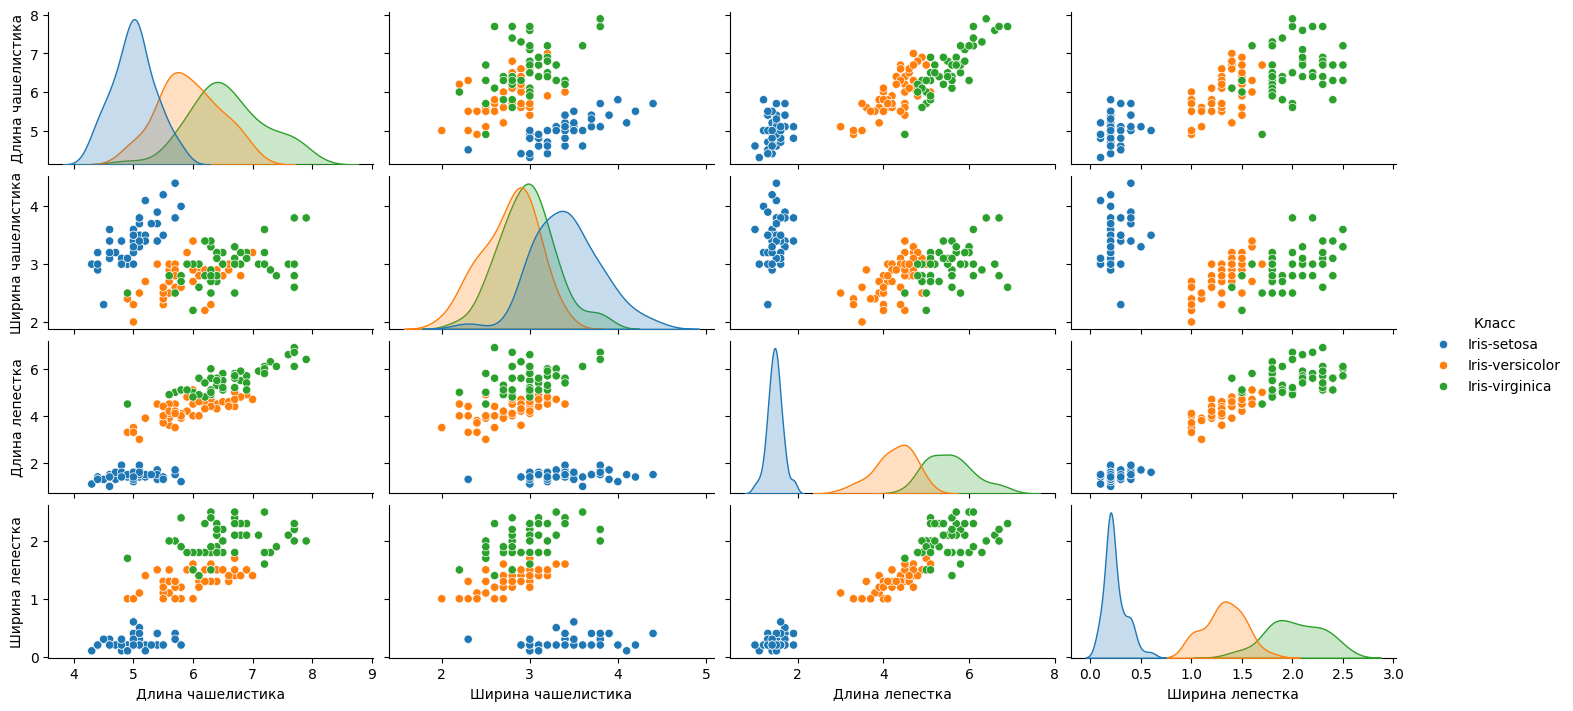

In [201]:
sns.pairplot(data, hue="Класс", markers="o", height=1.8, aspect=2)
plt.show()

Проанализировав графики, можно сказать, что Iris-setosa (синие точки) отделяется довольно четко от двух других видов, в то время как Iris-versicolor и Iris-virginica частично пересекаются. Это говорит о том, что разделение Iris-versicolor и Iris-virginica может быть сложнее

Метод k ближайших соседей (англ. kNN — k Nearest Neighbours): для повышения надёжности классификации объект относится к тому классу, которому принадлежит большинство из его соседей — k ближайших к нему объектов обучающей выборки x. Определим классификатор KNN и параметры для подбора модели

Будем рассматривать следующие метрики расстояния:
1) Евклидово расстояние — это наиболее простая и общепринятая метрика, которая определяется как длина отрезка между двумя объектами a и b в пространстве с n признаками и вычисляется по формуле: 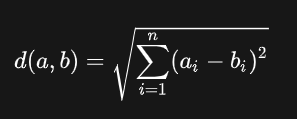
2) Манхэттенское расстояние — метрика, которая определяется как сумма модулей разностей координат двух точек в пространстве между двумя объектами a и b с n признаками и вычисляется по формуле: 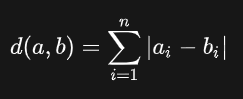
3) Косинусное расстояние — метрика, которая определяется как угол между двумя векторами a и b в пространстве с n признаками и вычисляется по формуле: 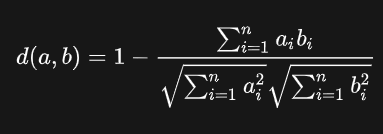

И следующие веса:
1) uniform: Все соседние точки имеют одинаковый вес, независимо от расстояния до классифицируемой точки. При этом предсказание основано на большинстве голосов соседей
2) distance: Вес соседних точек зависит от расстояния до классифицируемой точки — чем ближе сосед, тем больше его вклад в предсказание. Это позволяет учитывать, что более близкие точки могут быть более релевантными

In [202]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9], # количество соседей
    'weights': ['uniform', 'distance'], # типы взвешивания
    'metric': ['euclidean', 'manhattan', 'cosine'] # метрика расстояния
}

Используем GridSearchCV для поиска лучших параметров модели KNN с использованием кросс-валидации (cv=5). Перебор по сетке (Grid Search) — это метод подбора оптимальных гиперпараметров для модели путём перебора всех возможных комбинаций значений гиперпараметров из заданного набора. Алгоритм работы:
1) Для каждого гиперпараметра фиксируется несколько значений
2) Перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется
3) Выбирается комбинация, на которой модель показывает лучшее качество



cv (cross-validation) определяет количество фолдов (частей), на которые будет разделён обучающий набор данных для проведения кросс-валидации. Процесс обучения и оценки: Модель обучается 5 раз (столько же, сколько фолдов). Каждый раз модель тренируется на 4 из 5 фолдов и оценивается на оставшемся фолде. Это позволяет модели протестироваться на каждом фолде по одному разу, что уменьшает вероятность переоценки её качества. Итоговая метрика усредняется по всем 5 фолдам

In [203]:
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'cosine'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Проанализируем вывод: 

GridSearchCV выполнил поиск по сетке параметров для классификатора KNeighborsClassifier
1) cv=5: кросс-валидация на 5 фолдах
2) estimator=KNeighborsClassifier(): базовый классификатор, которым является KNeighborsClassifier
3) param_grid: словарь параметров, по которым выполняется поиск
4) scoring='accuracy': в качестве метрики для выбора наилучшей модели используется точность

best_estimator_: здесь представлен лучший классификатор, найденный в процессе подбора параметров. Лучшая модель имеет следующие параметры:
1) metric='cosine': косинусная метрика для измерения расстояния между объектами
2) n_neighbors=9: наилучшее число ближайших соседей для классификации — 3

Для подтверждения полученного результата информация о лучшем классификаторе была выведена повторно

In [204]:
best_knn = grid_search.best_estimator_ # извлекаем лучшую модель, найденную в ходе поиска по сетке параметров

Оценка на обучающей выборке

In [205]:
y_train_pred = best_knn.predict(X_train)

In [206]:
new_df = pd.DataFrame({'Actual': y_train, "Predicted": y_train_pred}) 
print(new_df.head())

             Actual        Predicted
22      Iris-setosa      Iris-setosa
15      Iris-setosa      Iris-setosa
65  Iris-versicolor  Iris-versicolor
11      Iris-setosa      Iris-setosa
42      Iris-setosa      Iris-setosa


Вычислим метрики Accuracy, Recall, Precision и F1 Score для оценки классификатора

1) Accuracy — это доля объектов, для которых правильно предсказали класс
2) Recall (полнота) показывает, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм. Полнота отвечает на вопрос: "Сколько из всех истинных положительных примеров удалось правильно предсказать?". Высокое значение recall говорит о том, что модель успешно находит большинство положительных примеров
3) precision (точность) — это доля истинно положительных ответов среди всех положительных ответов модели. Точность показывает, какая доля объектов, предсказанных моделью как принадлежащие к определенному классу, действительно относится к этому классу. Высокая точность означает, что большая часть примеров, предсказанных как положительные, действительно являются положительными
4) F1 Score -  это гармоническое среднее между precision и recall. Она дает единый показатель качества классификации, учитывая как полноту, так и точность. Формула: 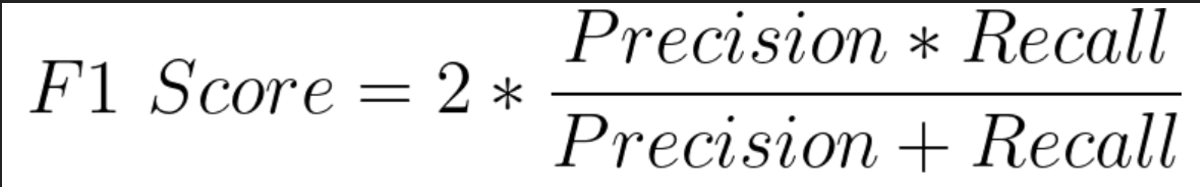

В нашей задаче положительные и отрицательные примеры зависят от рассматриваемого класса: например, если в определённый момент рассматриваем Iris-setosa как положительный класс, то все образцы Iris-setosa будут положительными примерами, а все остальные будут отрицательными. Для каждой метрики (precision, recall и др.) используются понятия "положительные" и "отрицательные" примеры, чтобы вычислить, насколько хорошо модель умеет классифицировать положительные объекты (то есть, принадлежащие к целевому классу)

In [207]:
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Recall: {recall_score(y_train, y_train_pred, average='weighted'):.2f}")
print(f"Precision: {precision_score(y_train, y_train_pred, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.2f}")

Accuracy: 0.98
Recall: 0.98
Precision: 0.98
F1 Score: 0.98


Все метрики имеют значение 0,98. Это говорит о том, что модель хорошо обучена на предоставленных данных

Оценка на тестовой выборке

In [208]:
y_pred = best_knn.predict(X_test)

In [209]:
new_df = pd.DataFrame({'Actual': y_test, "Predicted": y_pred}) 
print(new_df.head())

              Actual        Predicted
73   Iris-versicolor  Iris-versicolor
18       Iris-setosa      Iris-setosa
118   Iris-virginica   Iris-virginica
78   Iris-versicolor  Iris-versicolor
76   Iris-versicolor  Iris-versicolor


In [210]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")


Accuracy: 0.97
Recall: 0.97
Precision: 0.97
F1 Score: 0.97


Все метрики имеют значение 0.97, что говорит о том, что модель работает очень хорошо и показывает высокую точность